In [54]:
using Distributions
using JLD2
using LinearAlgebra
using Random
using StatsFuns: logsumexp, logaddexp

include("data_structures.jl");

In [55]:
"""
Sufficient statistics for a cluster in the object-aware HDP+,infinity.

These are the aggregate terms that appear in Eq. (28) of the writeup:
  - sum_kperS           : sum k_per S_i
  - sum_rho             : sum rho_i
  - sum_rho_ybar        : sum rho_i * ybar_i
  - sum_rho_ybar_norm2  : sum rho_i * ||ybar_i||^2
  - total_percepts      : sum O_i 
"""
Base.@kwdef mutable struct ObjectAwareHDPClusterStats
    n_obj::Int                    # number of objects assigned to this cluster
    total_percepts::Int           # total number of percepts across objects
    sum_kperS::Float64            # sum k_per S_i \in R
    sum_rho::Float64              # sum rho_i \in R
    sum_rho_ybar::Vector{Float64} # sum rho_i * ybar_i \in R^d
    sum_rho_ybar_norm2::Float64   # sum rho_i * ||ybar_i||^2 \in R
end

function ObjectAwareHDPClusterStats(d::Int)
    ObjectAwareHDPClusterStats(0, 0, 0.0, 0.0, zeros(d), 0.0)
end


ObjectAwareHDPClusterStats

In [56]:
"""
    add_object!(cs, ys, hyper; sign = +1)

Update cluster stats `cs` to add (sign = +1) or remove (sign = -1) a single
object whose percepts are `ys::Vector{Vector{Float64}}`.

Uses Eq. (27) to compute:
  - O_i, ybar_i, S_i
  - rho_i = k_per * O_i * k_obj / (k_per * O_i + k_obj)
and updates the aggregated cluster statistics accordingly.
"""
function add_object!(cs::ObjectAwareHDPClusterStats,
                     ys::Vector{Vector{Float64}},
                     hyper::ObjectAwareHDPHyperparams;
                     sign::Int = +1)
    @assert sign == 1 || sign == -1 "sign must be +1 or -1"

    k_obj = hyper.k_obj
    k_per = hyper.k_per
    Oi    = length(ys)
    @assert Oi > 0 "Each object must have at least one percept"

    d = length(ys[1])

    # Compute sample mean ybar_i and within-object scatter S_i
    sum_y = zeros(d)
    sumsq_y = 0.0
    for y in ys
        @assert length(y) == d "Percept dimensionality mismatch"
        @. sum_y += y
        sumsq_y += sum(abs2, y)
    end
    ybar = sum_y / Oi
    ybar_norm2 = sum(abs2, ybar)
    Si = sumsq_y - Oi * ybar_norm2

    # rho_i from Eq. (27) / (28)
    rho_i = k_per * Oi * k_obj / (k_per * Oi + k_obj)

    # Update cluster stats
    cs.n_obj          += sign
    cs.total_percepts += sign * Oi
    cs.sum_kperS      += sign * (k_per * Si)
    cs.sum_rho        += sign * rho_i
    @. cs.sum_rho_ybar += sign * (rho_i * ybar)
    cs.sum_rho_ybar_norm2 += sign * (rho_i * ybar_norm2)

    return cs
end


add_object!

In [57]:
"""
    posterior_hyperparams(cs, hyper) -> (kn, mn, an, bn)

Compute posterior hyperparameters of (mu, sigma^2) for a cluster with stats `cs`
under the object-aware HDP+,infinity model (Eq. 28 in the writeup).

Requires an Inverse-Gamma prior on sigma^2, so `a0` and `b0` must be set
(`sigma2` must be `nothing`).
"""
function posterior_hyperparams(cs::ObjectAwareHDPClusterStats,
                               hyper::ObjectAwareHDPHyperparams)
    a0 = hyper.a0
    b0 = hyper.b0
    if a0 === nothing || b0 === nothing
        error("Object-aware HDP currently requires a0 and b0 (IG prior); sigma2 fixed is not implemented.")
    end

    d     = length(hyper.m0)
    m0    = hyper.m0
    k_clu = hyper.k_clu

    @assert cs.total_percepts > 0 "Cluster must contain at least one percept"

    # Eq. (28)
    sum_rho   = cs.sum_rho
    kn        = k_clu + sum_rho
    mn        = (k_clu * m0 + cs.sum_rho_ybar) / kn
    an        = a0 + 0.5 * d * cs.total_percepts

    m0_norm2  = sum(abs2, m0)
    mn_norm2  = sum(abs2, mn)

    bn = b0 + 0.5 * (
        cs.sum_kperS +
        k_clu * m0_norm2 +
        cs.sum_rho_ybar_norm2 -
        kn * mn_norm2
    )

    return kn, mn, an, bn
end


posterior_hyperparams

In [58]:
"""
    stack_percepts(ys) -> Vector{Float64}

Stack O d-dimensional percepts into a single vector in R^(dO).
"""
function stack_percepts(ys::Vector{Vector{Float64}})
    return vcat(ys...)
end

"""
    log_predictive_object_existing_cluster(ys, cs, hyper)

Compute log p(y_i | existing cluster with stats `cs`)
using the multivariate t predictive (Eq. 29).
`ys` is a vector of percepts for one object.
"""
function log_predictive_object_existing_cluster(ys::Vector{Vector{Float64}},
                                        cs::ObjectAwareHDPClusterStats,
                                        hyper::ObjectAwareHDPHyperparams)
    @assert cs.total_percepts > 0 "Cluster must contain at least one percept"
    a0 = hyper.a0
    b0 = hyper.b0
    if a0 === nothing || b0 === nothing
        error("Object-aware HDP currently requires a0 and b0 (IG prior); sigma2 fixed is not implemented.")
    end

    d  = length(hyper.m0)
    Oi = length(ys)

    kn, mn, an, bn = posterior_hyperparams(cs, hyper)
    df = 2 * an

    # Mean H * mn  (stack mn O_i times)
    mu_vec = vcat((mn for _ in 1:Oi)...)

    # Covariance: (bn / an) * [ (1/kn + 1/k_obj) (J_O \otimes I_d) + (1/k_per) I_(dO) ]
    I_d   = Matrix{Float64}(I, d, d)
    JO    = ones(Oi, Oi)
    J_kron = kron(JO, I_d)
    I_big = Matrix{Float64}(I, d * Oi, d * Oi)

    Sigma_inner = (1 / kn + 1 / hyper.k_obj) * J_kron + (1 / hyper.k_per) * I_big
    Sigma = (bn / an) * Sigma_inner

    y_vec = stack_percepts(ys)
    dist = MvTDist(df, mu_vec, Sigma)
    return logpdf(dist, y_vec)
end

"""
    log_predictive_object_new_cluster(ys, hyper)

Compute log p(y_i | new cluster) using the prior-only predictive
(Eq. 30).
"""
function log_predictive_object_new_cluster(ys::Vector{Vector{Float64}},
                                   hyper::ObjectAwareHDPHyperparams)
    a0 = hyper.a0
    b0 = hyper.b0
    if a0 === nothing || b0 === nothing
        error("Object-aware HDP currently requires a0 and b0 (IG prior); sigma2 fixed is not implemented.")
    end

    d  = length(hyper.m0)
    Oi = length(ys)

    df = 2 * a0
    m0 = hyper.m0

    # Mean H * m0  (stack m0 O_i times)
    mu_vec = vcat((m0 for _ in 1:Oi)...)

    # Covariance: (b0 / a0) * [ (1/k_clu + 1/k_obj)(J_O ⊗ I_d) + (1/k_per) I_(dO) ]
    I_d   = Matrix{Float64}(I, d, d)
    JO    = ones(Oi, Oi)
    J_kron = kron(JO, I_d)
    I_big = Matrix{Float64}(I, d * Oi, d * Oi)

    Sigma_inner = (1 / hyper.k_clu + 1 / hyper.k_obj) * J_kron + (1 / hyper.k_per) * I_big
    Sigma = (b0 / a0) * Sigma_inner

    y_vec = stack_percepts(ys)
    dist = MvTDist(df, mu_vec, Sigma)
    return logpdf(dist, y_vec)
end


log_predictive_object_new_cluster

In [59]:
"""
    gibbs_sweep_objects!(objects, z, clusters, hyper; rng=Random.default_rng())

One collapsed-Gibbs sweep over all OBJECTS for a single category in the
object-aware HDP+,infinity.

- objects  :: Vector{Vector{Vector{Float64}}}
    objects[i] is a vector of percepts for object i;
    each percept is a d-dimensional Vector{Float64}.

- z        :: Vector{Int}
    cluster labels for objects (1..K)

- clusters :: Vector{ObjectAwareHDPClusterStats}
    stats for each active cluster

- hyper    :: ObjectAwareHDPHyperparams
"""
function gibbs_sweep_objects!(objects::Vector{Vector{Vector{Float64}}},
                              z::Vector{Int},
                              clusters::Vector{ObjectAwareHDPClusterStats},
                              hyper::ObjectAwareHDPHyperparams;
                              rng = Random.default_rng())
    N = length(objects)
    @assert length(z) == N "z must have one entry per object"

    d = length(objects[1][1])
    Kmax = length(clusters) + N
    log_total = log(N - 1 + hyper.alpha)

    # Work buffers
    logps = Vector{Float64}(undef, Kmax + 1)
    idxs  = Vector{Int}(undef, Kmax + 1)

    # Log-space sampler (same style as traditional HDP)
    @inline function sample_from_logweights(logw::Vector{Float64}, n::Int, rng)
        max_logw = maximum(@view logw[1:n])
        @inbounds logw[1:n] .-= max_logw
        logZ = logsumexp(@view logw[1:n])
        threshold = log(rand(rng)) + logZ
        acc = -Inf
        @inbounds for k in 1:n
            acc = logaddexp(acc, logw[k])
            if acc >= threshold
                return k
            end
        end
        return n
    end

    # Main Gibbs loop over objects
    for i in 1:N
        ys = objects[i]

        # 1. Remove object from its current cluster
        k_old = z[i]
        add_object!(clusters[k_old], ys, hyper; sign = -1)
        # cluster may become empty (n_obj == 0)

        # 2. Compute unnormalized log posterior for each active cluster + new
        K = length(clusters)
        @inbounds fill!(logps, -Inf)
        n_active = 0

        # Existing clusters
        @inbounds for k in 1:K
            nk = clusters[k].n_obj
            if nk == 0
                continue
            end
            n_active += 1
            idxs[n_active] = k

            log_crp_prior = log(nk) - log_total
            log_like      = log_predictive_object_existing_cluster(ys, clusters[k], hyper)
            logps[n_active] = log_crp_prior + log_like
        end

        # New cluster option
        new_idx = n_active + 1
        log_crp_prior_new = log(hyper.alpha) - log_total
        log_like_new      = log_predictive_object_new_cluster(ys, hyper)
        logps[new_idx] = log_crp_prior_new + log_like_new

        # 3. Sample new assignment
        k_choice = sample_from_logweights(logps, new_idx, rng)

        if k_choice == new_idx
            # Assign to a (possibly reused) empty cluster
            empty_idx = findfirst(c -> c.n_obj == 0, clusters)
            if empty_idx === nothing
                cs_new = ObjectAwareHDPClusterStats(d)
                add_object!(cs_new, ys, hyper; sign = +1)
                push!(clusters, cs_new)
                z[i] = length(clusters)
            else
                add_object!(clusters[empty_idx], ys, hyper; sign = +1)
                z[i] = empty_idx
            end
        else
            # Assign to existing active cluster
            k_new = idxs[k_choice]
            add_object!(clusters[k_new], ys, hyper; sign = +1)
            z[i] = k_new
        end
    end
end


gibbs_sweep_objects!

In [60]:
"""
    object_aware_hdp_cluster_update(objects, hyper; iters=1000, rng=Random.default_rng())

Run collapsed Gibbs sampling for one category under the object-aware HDP+,infinity.

- objects :: Vector{Vector{Vector{Float64}}}
    objects[i] is the list of percepts for object i
    (each percept is a d-dimensional vector).

Returns (z, clusters):
  - z        :: Vector{Int}  (cluster labels for each object)
  - clusters :: Vector{ObjectAwareHDPClusterStats}
"""
function object_aware_hdp_cluster_update(objects::Vector{Vector{Vector{Float64}}},
                                         hyper::ObjectAwareHDPHyperparams;
                                         iters::Int = 1000,
                                         rng = Random.default_rng())
    N = length(objects)
    @assert N > 0 "Need at least one object"

    d = length(objects[1][1])
    @assert length(hyper.m0) == d "Mismatch between hyper.m0 dimension and percept dimension"

    # Initialize: each object in its own cluster
    z = collect(1:N)
    clusters = [ObjectAwareHDPClusterStats(d) for _ in 1:maximum(z)]
    for i in 1:N
        add_object!(clusters[z[i]], objects[i], hyper)
    end

    # Gibbs sweeps
    for it in 1:iters
        gibbs_sweep_objects!(objects, z, clusters, hyper; rng = rng)
    end

    return z, clusters
end


object_aware_hdp_cluster_update

In [61]:
@load "train_test_splits.jld2" cat1_splits cat2_splits;

In [68]:
objects = [obj.percepts for obj in cat1_splits[50].train_objects_skewed]

hyper = ObjectAwareHDPHyperparams(
    m0    = [0.0, 0.0],
    k_clu = 1.0,
    k_obj = 5.0,
    k_per = 20.0,
    a0    = 1.0,
    b0    = 1.0,
    alpha = 1.0,
)

temp_z, temp_clu = object_aware_hdp_cluster_update(objects, hyper; iters = 5000);
length(unique(temp_z))

3

In [67]:
using Plots

"""
    plot_clusters(pts, labels; markersize=6)

Plot 2D points `pts` colored by their cluster `labels`.
`pts` is assumed to be a vector of (x, y) pairs.
"""
function plot_clusters(pts, labels)
    @assert length(pts) == length(labels)

    unique_labels = unique(labels)

    plt = plot()  # empty plot

    for lab in unique_labels
        idx = findall(==(lab), labels)
        xs = first.(pts[idx])
        ys = last.(pts[idx])
        scatter!(plt, xs, ys;
                 label = "Cluster $lab",
                 marker = :circle, ms = 4,
                 alpha=0.5, markerstrokewidth=0.5)
    end

    plot!(plt, xlabel="x1", ylabel="x2", legend=:outerright)
end


plot_clusters

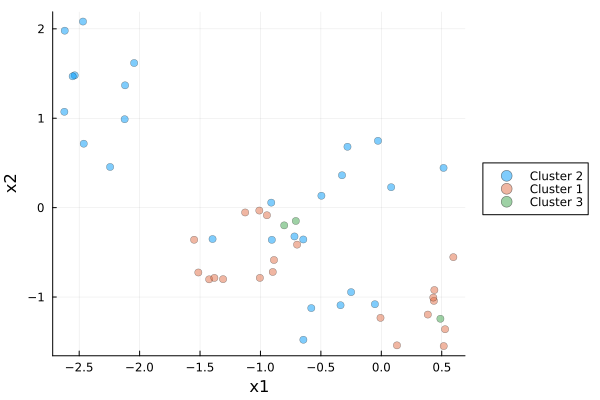

In [69]:
percepts = vcat((obj.percepts for obj in cat1_splits[50].train_objects_uniform)...);
z_for_percepts = [ temp_z[i]              # the object's z
                   for (i, obj) in enumerate(objects)
                   for _ in obj  # repeat once per percept
                 ]
v = unique(z_for_percepts)
p = sortperm(v)
rank = similar(v)
rank[p] = 1:length(v)
rankmap = Dict(v[i] => rank[i] for i in eachindex(v))
replaced_z = [ get(rankmap, val, val) for val in z_for_percepts ];
plot_clusters(percepts, replaced_z)

In [65]:
# total number of training objects
function total_objects(clusters::Vector{ObjectAwareHDPClusterStats})
    s = 0
    for cs in clusters
        s += cs.n_obj
    end
    return s
end

total_objects (generic function with 1 method)

In [ ]:
"""
    log_predictive_percept_existing_cluster(y_new, cs, hyper)

Compute log p(y_new | existing cluster with stats `cs`, object-aware HDP+,infinity).

This is the single-percept special case of the object-aware predictive (analogous
to Eq. (29)), treating y_new as the only percept of a new object assigned to this
cluster.
"""
function log_predictive_percept_existing_cluster(y_new::Vector{Float64},
                                                 cs::ObjectAwareHDPClusterStats,
                                                 hyper::ObjectAwareHDPHyperparams)
    @assert cs.total_percepts > 0 "Need at least one percept in the cluster"
    a0 = hyper.a0
    b0 = hyper.b0
    if a0 === nothing || b0 === nothing
        error("Object-aware predictive requires a0 and b0 (IG prior).")
    end

    d = length(y_new)
    kn, mn, an, bn = posterior_hyperparams(cs, hyper)

    df = 2 * an
    scale = (bn / an) * (1 / kn + 1 / hyper.k_obj + 1 / hyper.k_per)
    Sigma = scale * Matrix(1.0I, d, d)

    dist = MvTDist(df, mn, Sigma)
    return logpdf(dist, y_new)
end


log_predictive_percept_existing_cluster

In [ ]:
"""
    log_predictive_percept_new_cluster(y_new, hyper)

Compute log p(y_new | new cluster) under the object-aware HDP+,∞.

Implements Eq. (31), i.e. a new object with exactly one percept.
"""
function log_predictive_percept_new_cluster(y_new::Vector{Float64},
                                            hyper::ObjectAwareHDPHyperparams)
    a0 = hyper.a0
    b0 = hyper.b0
    if a0 === nothing || b0 === nothing
        error("Object-aware predictive requires a0 and b0 (IG prior).")
    end

    d = length(y_new)
    m0 = hyper.m0

    df = 2 * a0
    scale = (b0 / a0) * (1 / hyper.k_clu + 1 / hyper.k_obj + 1 / hyper.k_per)
    Sigma = scale * Matrix(1.0I, d, d)

    dist = MvTDist(df, m0, Sigma)
    return logpdf(dist, y_new)
end


log_predictive_percept_new_cluster

In [72]:
"""
    log_post_pred_y(y_new, clusters, hyper)

Implements the object-aware analogue of Eq. (23) for a *single percept* y_new.

We treat y_new as belonging to a new object x* that has only this one percept,
and compute:

  P(y_new | y) = sum_k n_k/(I+alpha) * P(y_new | cluster k)
                 + alpha/(I+alpha)   * P(y_new | new cluster)

where:
- clusters :: Vector{ObjectAwareHDPClusterStats} are the *training* clusters
- hyper    :: ObjectAwareHDPHyperparams
"""
function log_post_pred_y(y_new::Vector{Float64},
                         clusters::Vector{ObjectAwareHDPClusterStats},
                         hyper::ObjectAwareHDPHyperparams)

    K = length(clusters)
    I = total_objects(clusters)   # total # of training objects
    alpha = hyper.alpha

    # If no training objects, fall back to pure prior predictive (new cluster)
    if I == 0
        return log_predictive_percept_new_cluster(y_new, hyper)
    end

    log_terms = Vector{Float64}(undef, K + 1)
    @inbounds fill!(log_terms, -Inf)

    # existing clusters
    for k in 1:K
        nk = clusters[k].n_obj
        if nk == 0
            continue  # skip empty clusters
        end
        prior_weight = nk / (I + alpha)
        log_lik = log_predictive_percept_existing_cluster(y_new, clusters[k], hyper)
        log_terms[k] = log(prior_weight) + log_lik
    end

    # new cluster term
    prior_new   = alpha / (I + alpha)
    log_lik_new = log_predictive_percept_new_cluster(y_new, hyper)
    log_terms[K + 1] = log(prior_new) + log_lik_new

    # log-sum-exp to get log P(y_new | y)
    return logsumexp(log_terms)
end


log_post_pred_y

In [ ]:
objects = [obj.percepts for obj in cat1_splits[50].train_objects_skewed]

-1.0737555262860585

In [79]:
hyper = ObjectAwareHDPHyperparams(
    m0    = [0.0, 0.0],
    k_clu = 1.0,
    k_obj = 5.0,
    k_per = 20.0,
    a0    = 1.0,
    b0    = 1.0,
    alpha = 1.0,
)
n_splits = length(cat2_splits)
n_test_per_cat = 50
cat1_performance = Vector{Float64}(undef, n_splits)
cat2_performance = Vector{Float64}(undef, n_splits)

for i in 1:n_splits
    cat1_correct = cat2_correct = 0
    cat1_train = [obj.percepts for obj in cat1_splits[i].train_objects_uniform]
    cat2_train = [obj.percepts for obj in cat2_splits[i].train_objects_uniform]

    cat1_z, cat1_clu = object_aware_hdp_cluster_update(cat1_train, hyper; iters=1000)
    cat2_z, cat2_clu = object_aware_hdp_cluster_update(cat2_train, hyper; iters=1000)

    cat1_test = vcat((obj.percepts for obj in cat1_splits[i].test_objects)...)
    for j in 1:length(cat1_test)
        logp_test_given_cat1 = log_post_pred_y(cat1_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_y(cat1_test[j], cat2_clu, hyper)
        cat1_correct += logp_test_given_cat1 > logp_test_given_cat2
    end
    cat1_performance[i] = cat1_correct 

    cat2_test = vcat((obj.percepts for obj in cat2_splits[i].test_objects)...)
    for j in 1:length(cat2_test)
        logp_test_given_cat1 = log_post_pred_y(cat2_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_y(cat2_test[j], cat2_clu, hyper)
        cat2_correct += logp_test_given_cat1 < logp_test_given_cat2
    end 
    cat2_performance[i] = cat2_correct 
end 

println(cat1_performance ./ n_test_per_cat)
println(cat2_performance ./ n_test_per_cat)

[0.96, 0.94, 0.98, 0.98, 0.92, 0.96, 0.88, 0.98, 0.56, 0.92, 0.84, 0.98, 0.9, 0.96, 1.0, 0.98, 0.92, 0.72, 0.92, 0.98, 0.98, 0.94, 0.98, 0.88, 0.92, 0.86, 0.94, 1.0, 1.0, 0.78, 0.82, 1.0, 0.96, 0.98, 1.0, 0.74, 0.84, 0.96, 0.84, 0.96, 0.9, 0.98, 0.84, 0.96, 0.9, 0.8, 0.92, 0.88, 0.94, 1.0, 0.92, 0.86, 0.98, 0.94, 0.92, 1.0, 0.96, 0.94, 1.0, 0.94]
[0.88, 0.88, 0.94, 1.0, 0.9, 1.0, 0.9, 0.96, 1.0, 0.86, 0.9, 0.98, 0.9, 1.0, 1.0, 0.88, 0.94, 0.96, 0.86, 0.86, 0.92, 0.9, 0.94, 0.9, 0.96, 0.9, 0.9, 0.98, 0.9, 0.84, 0.9, 0.92, 1.0, 0.96, 0.74, 0.9, 0.88, 0.86, 0.88, 1.0, 0.9, 0.94, 0.96, 0.86, 0.9, 0.9, 1.0, 0.82, 0.94, 0.94, 0.88, 0.88, 0.98, 0.96, 0.9, 0.88, 0.98, 0.88, 0.96, 1.0]


In [81]:
mean(cat1_performance ./ n_test_per_cat), mean(cat2_performance ./ n_test_per_cat)

(0.9206666666666666, 0.9206666666666667)

In [82]:
sum(cat1_performance .> cat2_performance)

28